In [2]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

# import requests
# s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
# plt.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
PARQA = os.getenv('PARQA')

## Calls to Districts

In [4]:
calls = pd.read_csv(PARQA + 'data/311/MatchedCalls.cav', index_col=0)

In [5]:
calls.head()

,Closed Date,Created Date,Location Type,NAME,Complaint Type,Descriptor,lat,lon,parkDistrict
0,01/03/2011 12:03:59 PM,12/31/2010 09:04:48 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.931120,40.668798,B-09
3,01/03/2011 09:41:24 AM,12/31/2010 03:36:37 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.962835,40.688556,B-02
4,01/03/2011 12:15:38 PM,12/31/2010 03:03:16 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.999809,40.636935,B-12
6,01/03/2011 12:23:04 PM,12/31/2010 12:59:59 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.999456,40.609951,B-11
7,01/03/2011 12:19:51 PM,12/31/2010 12:12:02 PM,Park,NaN,Maintenance or Facility,Snow or Ice,-73.977616,40.633153,B-14


In [6]:
callsByDistr = pd.DataFrame(calls.parkDistrict.value_counts()).reset_index().rename(columns={'parkDistrict':'calls',
                                                                                             'index':'parkDistrict'})

In [7]:
districts = gp.read_file(PARQA + 'data/Districts/Districts_tmp.geojson')

In [8]:
districts.head(2)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,...",0
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ...",1


In [9]:
districtsAll = districts.merge(callsByDistr, how='left', left_on='SYSTEM',right_on='parkDistrict' )
                           

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,parkDistrict,calls
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,...",0,M-01,1126
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ...",1,M-02,1373


In [13]:
districtsAll.sort_values('calls', ascending=0).head(5) 

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,id,parkDistrict,calls,calls_normalised
7,None,M,164,8,3.830553e+07,32711.130377,M-13,"POLYGON ((995706.8963655531 230733.0110245645,...",7,M-13,3949,0.000103
61,None,M,"107, 109","6, 7, 9",1.627452e+07,49244.093392,M-14,"POLYGON ((988529.7433970571 225891.3002355546,...",61,M-14,3756,0.000231
65,None,M,103,"1, 2",4.339118e+07,30121.257864,M-03,"POLYGON ((986756.3256840557 197828.4469125569,...",65,M-03,3037,0.000070
60,None,M,112,"7, 10",6.952111e+07,56221.985932,M-12,"POLYGON ((998064.6764268875 243352.0304058939,...",60,M-12,2716,0.000039
21,None,B,301,"35, 33, 34",1.354542e+08,50817.429779,B-01,"POLYGON ((1005885.061048552 197715.4707605541,...",21,B-01,2670,0.000020


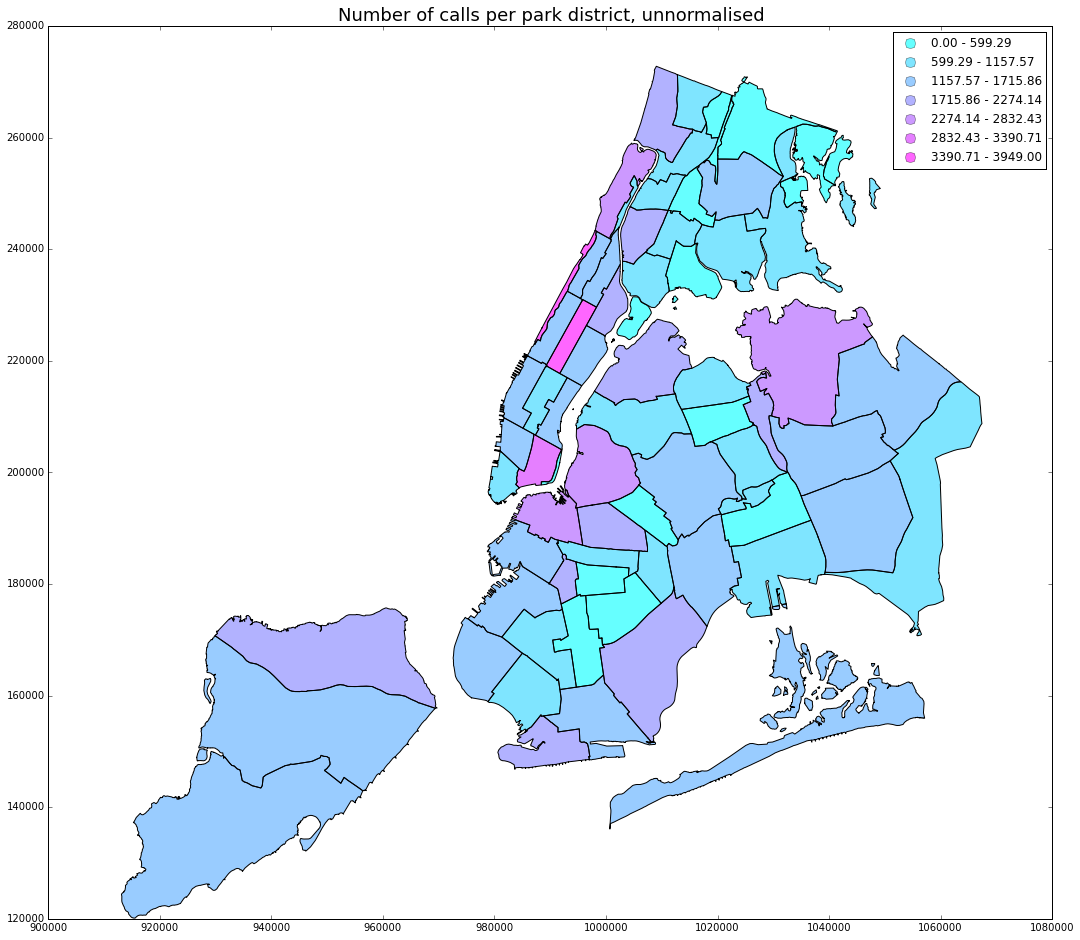

In [17]:
districtsAll.plot(figsize=(18,18), scheme='equal_interval', alpha=0.6, k=7, legend=True, column='calls', colormap='cool');
plt.title('Number of calls per park district, unnormalised',fontsize=18);
plt.legend()
plt.savefig(PARQA + 'parqa/311/img/map1.png')


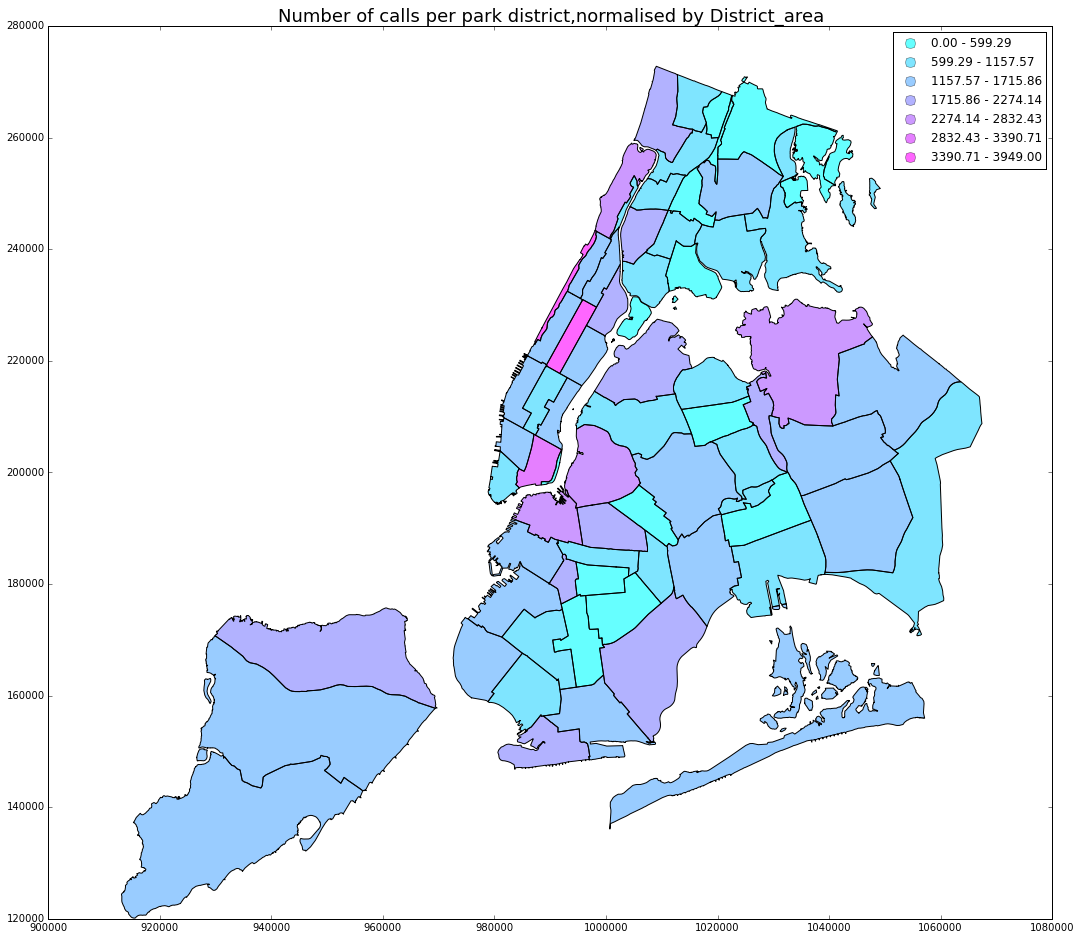

In [18]:
# now using shape area: need to calculate parks area per district.
districtsAll['calls_normalised'] = districtsAll['calls']/districtsAll['SHAPE_Area']
districtsAll.plot(figsize=(18,18), scheme='equal_interval', alpha=0.6, k=7, legend=True, column='calls', colormap='cool');

plt.title('Number of calls per park district,normalised by District_area',fontsize=18);
plt.savefig(PARQA + 'parqa/311/img/map2.png')

## Mapping Pike Calls

In [ ]:
import 